# Benchmarking cell2location pyro model using softplus/exp for scales

In [1]:
import sys, ast, os
#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib as mpl
data_type='float32'

#import cell2location_model
#import cell2location_module_scvi
import scvi
import torch

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/'

## Read datasets and train cell2location

Data can be downloaded as follows:

```bash
wget https://cell2location.cog.sanger.ac.uk/paper/synthetic_with_tissue_zones/synth_adata_real_mg_20210131.h5ad
wget https://cell2location.cog.sanger.ac.uk/paper/synthetic_with_tissue_zones/training_5705STDY8058280_5705STDY8058281_20210131.h5ad
```

In [3]:
adata_vis = anndata.read(f'{sp_data_folder}synth_adata_real_mg_20210131.h5ad')
adata_vis.uns['spatial'] = {'x': 'y'}
#adata_vis = adata_vis[adata_vis.obs['sample'].isin([f'exper{i}' for i in range(5,10)]),:]

adata_snrna_raw = anndata.read(f'{sp_data_folder}training_5705STDY8058280_5705STDY8058281_20210131.h5ad')

In [4]:
import scipy
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)

Add counts matrix as `adata.raw` 

In [5]:
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

In [6]:
# compute average for each cluster
aver = scvi.external.cell2location.compute_cluster_averages(adata_snrna_raw, 'annotation_1')

# make sure the order of gene matches between aver and x_data
aver = aver.loc[adata_vis.var_names,:]

# generate one-hot encoded matrix telling which obs belong to whic samples
obs2sample_df = pd.get_dummies(adata_vis.obs['sample'])

## Model training

In [7]:
adata_vis, aver = scvi.external.cell2location.intersect_var(
    adata=adata_vis, cell_state_df=aver)
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/ca

INFO     Successfully registered anndata object containing 25000 cells, 12809 vars, 10       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
scvi.data.view_anndata_setup(adata_vis)

In [9]:
mod = scvi.external.Cell2location(adata_vis, cell_state_df=aver,
                                  batch_size=2500, 
                                  amortised=True, 
                                  encoder_kwargs={'n_layers': 1, 'n_hidden': 200,
                                                  'dropout_rate': 0.2,
                                                  'activation_fn': torch.nn.ReLU},
                                  N_cells_per_location=8)

In [10]:
mod.train(max_epochs=1000, lr=0.005, autoencoding_lr=0.01, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1000:   0%|          | 0/1000 [00:00<?, ?it/s]

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  warnings.warn(*args, **kwargs)


Epoch 1000/1000: 100%|██████████| 1000/1000 [59:30<00:00,  3.57s/it, v_num=1, train_loss_step=3.12e+8, train_loss_epoch=3.12e+8]


In [11]:
means = mod.posterior_quantile(use_gpu = True)

In [12]:
means['w_sf'].shape

(25000, 49)

In [13]:
mod_m = scvi.external.Cell2location(adata_vis, cell_state_df=aver,
                                    batch_size=1250, 
                                  amortised=True, single_encoder=False,
                                  encoder_kwargs={'n_layers': 1, 'n_hidden': 200,
                                                  'dropout_rate': 0.2,
                                                  'activation_fn': torch.nn.ReLU},
                                  N_cells_per_location=8)

In [14]:
mod_m.train(max_epochs=1000, lr=0.005, autoencoding_lr=0.01, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1000:   0%|          | 0/1000 [00:00<?, ?it/s]

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  warnings.warn(*args, **kwargs)


Epoch 1000/1000: 100%|██████████| 1000/1000 [1:09:52<00:00,  4.19s/it, v_num=1, train_loss_step=3.12e+8, train_loss_epoch=3.12e+8]


In [15]:
means_m = mod_m.posterior_quantile(use_gpu = True)

### Compare ELBO as training progresses

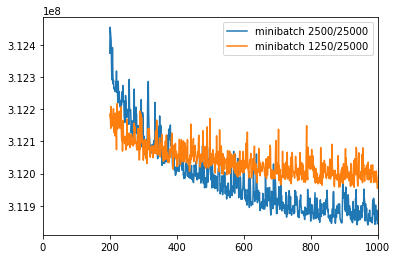

In [16]:
plt.plot(mod.module.history_['train_loss_epoch'].index[200:], 
         np.array(mod.module.history_['train_loss_epoch'].values.flatten())[200:]);
plt.plot(mod_m.module.history_['train_loss_epoch'].index[200:], 
         np.array(mod_m.module.history_['train_loss_epoch'].values.flatten())[200:]);
plt.legend(labels=['minibatch 2500/25000', 'minibatch 1250/25000']);
plt.xlim(0, len(mod_m.module.history_['train_loss_epoch']));

### Evaluate accuracy using $R^2$

In [17]:
from re import sub
cell_count = adata_vis.obs.loc[:, ['cell_abundances_' in i for i in adata_vis.obs.columns]]
cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
cell_count_columns = cell_count.columns
cell_proportions = (cell_count.T / cell_count.sum(1)).T

infer_cell_count = pd.DataFrame(means['w_sf'], index=adata_vis.obs_names, 
                                columns=aver.columns)
infer_cell_count = infer_cell_count[cell_count.columns]
infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T

infer_cell_count_m = pd.DataFrame(means_m['w_sf'], index=adata_vis.obs_names, 
                                columns=aver.columns)
infer_cell_count_m = infer_cell_count_m[cell_count.columns]
infer_cell_proportions_m = (infer_cell_count_m.T / infer_cell_count_m.sum(1)).T

In [18]:
infer_cell_count.iloc[0:5,0:5], infer_cell_count_m.iloc[0:5,0:5]

(                      Inh_3   Ext_Pir   Oligo_2  Astro_HYPO   Ext_L25
 exper0_location_0  0.249056  0.981656  0.069532    0.185206  0.269575
 exper0_location_1  0.267222  1.252501  0.085793    0.072740  0.194511
 exper0_location_2  0.264130  0.396755  0.050656    0.218254  0.212345
 exper0_location_3  0.266209  0.558005  0.383937    0.100096  0.207282
 exper0_location_4  0.294772  0.837525  0.288441    0.047432  0.112455,
                       Inh_3   Ext_Pir   Oligo_2  Astro_HYPO   Ext_L25
 exper0_location_0  0.945027  1.130105  0.051870    0.158418  0.164634
 exper0_location_1  0.987631  1.267524  0.042133    0.064591  0.145613
 exper0_location_2  0.672291  0.328952  0.028056    0.181243  0.140475
 exper0_location_3  1.060879  0.287411  0.086691    0.083191  0.124451
 exper0_location_4  0.971236  0.363413  0.059816    0.039768  0.049728)

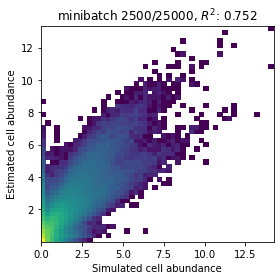

In [19]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count.values.flatten(),# / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[50, 50], norm=mpl.colors.LogNorm());
plt.xlabel('Simulated cell abundance');
plt.ylabel('Estimated cell abundance');
plt.title(r'minibatch 2500/25000, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count.values.flatten()), 3)[0,1]));
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig(fig_path + '/Cell_density_cor.pdf')

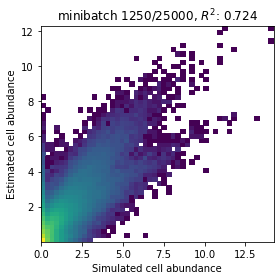

In [20]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count_m.values.flatten(),# / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[50, 50], norm=mpl.colors.LogNorm());
plt.xlabel('Simulated cell abundance');
plt.ylabel('Estimated cell abundance');
plt.title(r'minibatch 1250/25000, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count_m.values.flatten()), 3)[0,1]));
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig(fig_path + '/Cell_density_cor.pdf')

Original implementation of cell2location in pymc3 has $R^2 = 0.791$.

## Evaluate with PR curves

In [21]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']


def compute_precision_recall(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = average_precision_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = precision_recall_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.37),
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=3)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=3)
            
        
        lines.append(l)

        labels.append(method_title[i] + '(' + curve + ' score = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=8))

    #plt.show()
    return roc

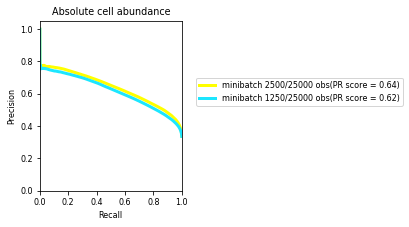

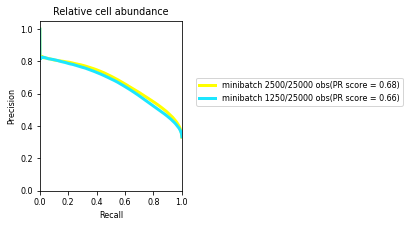

In [22]:
rcParams['figure.figsize'] = 6, 3
rcParams['font.size'] = 8

results = [
    infer_cell_count,
    infer_cell_count_m
]

results_proportion = [
    infer_cell_proportions,
    infer_cell_proportions_m
]

names = [
    'minibatch 2500/25000 obs', 
    'minibatch 1250/25000 obs',
]

compare_precision_recall(cell_count.values > 0.1, 
                         results,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout();
plt.title('Absolute cell abundance');
plt.show();

compare_precision_recall(cell_count.values > 0.1, 
                         results_proportion,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout();
plt.title('Relative cell abundance');
plt.show();

Original implementation of cell2location in pymc3 has PR score = 0.66.

### $R^2$ stratified by abundance and regional pattern

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/scipy/spatial/distance.py:1293: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)


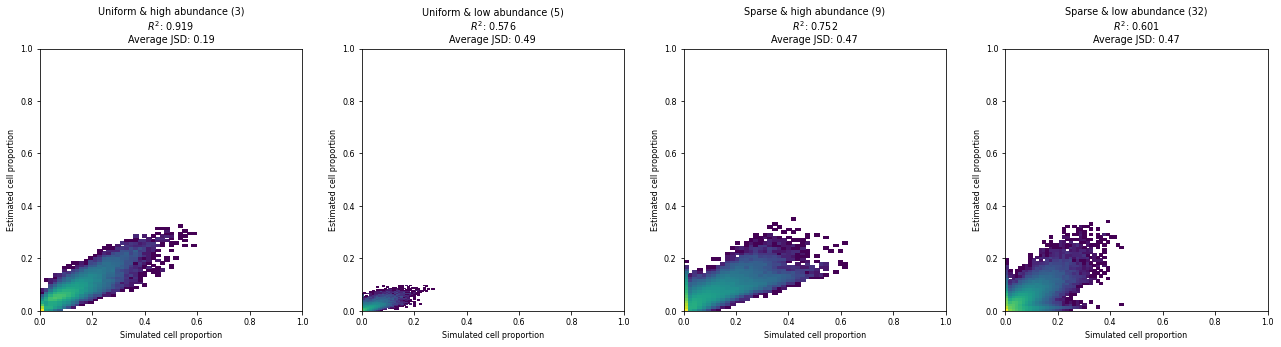

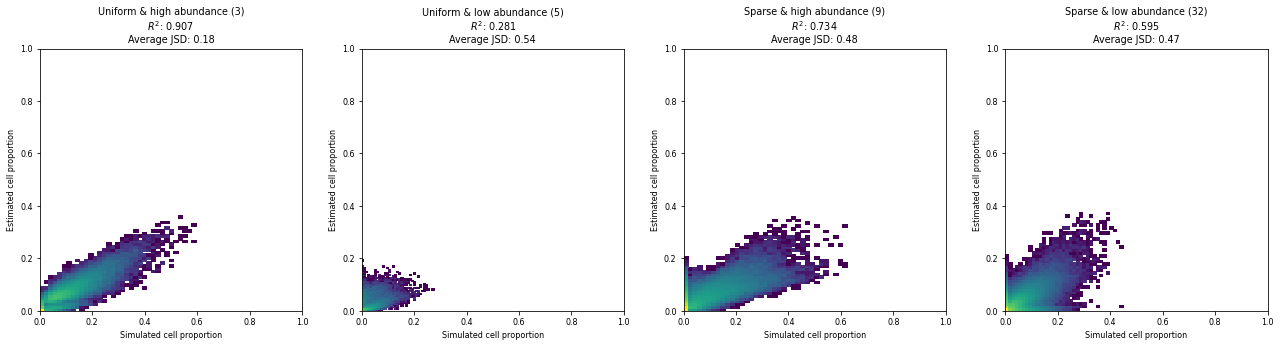

In [23]:
from scipy.spatial.distance import jensenshannon

def hist_obs_sim(cell_count, infer_cell_count,
                 xlab='Simulated cell proportion',
                 ylab='Estimated cell proportion',
                 title='', compute_kl=True, equal=True, max_val=1):
    
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    title = title +'\n'+ r'$R^2$: ' + str(cor)
    
    if compute_kl:
        
        js = np.array([jensenshannon(cell_count.values[r,:], infer_cell_count.values[r,:]) 
                 for r in range(cell_count.shape[0])])
        js = np.mean(js[~np.isnan(js)])
        title = title + '\nAverage JSD: ' + str(np.round(js, 2))
    
    plt.hist2d(cell_count.values.flatten(), 
               infer_cell_count.values.flatten(),
               bins=[35, 35], norm=mpl.colors.LogNorm());
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    if equal:
        plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, max_val);
    plt.ylim(0, max_val);
    plt.title(title);
    
def hist_by_category(cell_count, infer_cell_count, design,
                 xlab='Simulated cell proportion',
                 ylab='Estimated cell proportion',
                 nrow=1, ncol=4, compute_kl=True, equal=True):

    design_loc = design.loc[cell_count.columns,:]
    
    max_val = np.array([cell_count.values.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    plt.subplot(nrow, ncol, 1)
    ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Uniform & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 2)
    ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Uniform & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Sparse & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Sparse & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)

rcParams['figure.figsize'] = 18,4.5 
rcParams["axes.facecolor"] = "white"
hist_by_category(cell_proportions, infer_cell_proportions, adata_vis.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Estimated cell proportion',
                 nrow=1, ncol=4, equal=True)
plt.tight_layout();
plt.show();

hist_by_category(cell_proportions, infer_cell_proportions_m, adata_vis.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Estimated cell proportion',
                 nrow=1, ncol=4, equal=True)
plt.tight_layout();
plt.show();

In [24]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.20.0
IPython.core.release 7.20.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.4
pexpect 4.8.0
ptyprocess 0.7.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.0
parso 0.8.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.9
scanpy 1.7.0
scanpy._metadata 1.7.0
packaging 20.9
packaging.__about__ 20.9
importlib_metadata 1.7.0
csv 1.0
_csv 1.0
numpy 1.20.0
numpy.core 1.20.0
numpy.core._multiarray_umath 3.1
numpy.lib 1.20.0
numpy.linalg.